# Conditional GAN на MNIST

В этом ноутбуке мы реализуем и обучим условную генеративно-состязательную сеть (Conditional GAN) для генерации изображений цифр из датасета MNIST по заданному числу.

**Conditional GAN (cGAN)** расширяет обычный GAN, добавляя условие (label) в генератор и дискриминатор:
- **Generator (Генератор)** - создает изображение цифры на основе случайного шума и заданного числа (0-9)
- **Discriminator (Дискриминатор)** - проверяет, является ли изображение настоящим и соответствует ли оно заданному числу

Это позволяет контролировать, какую именно цифру генерировать.


## Импорты


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


Seed set to 42


42

## Загрузка и визуализация датасета MNIST

Сначала загрузим датасет MNIST и посмотрим на примеры изображений с их метками.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)


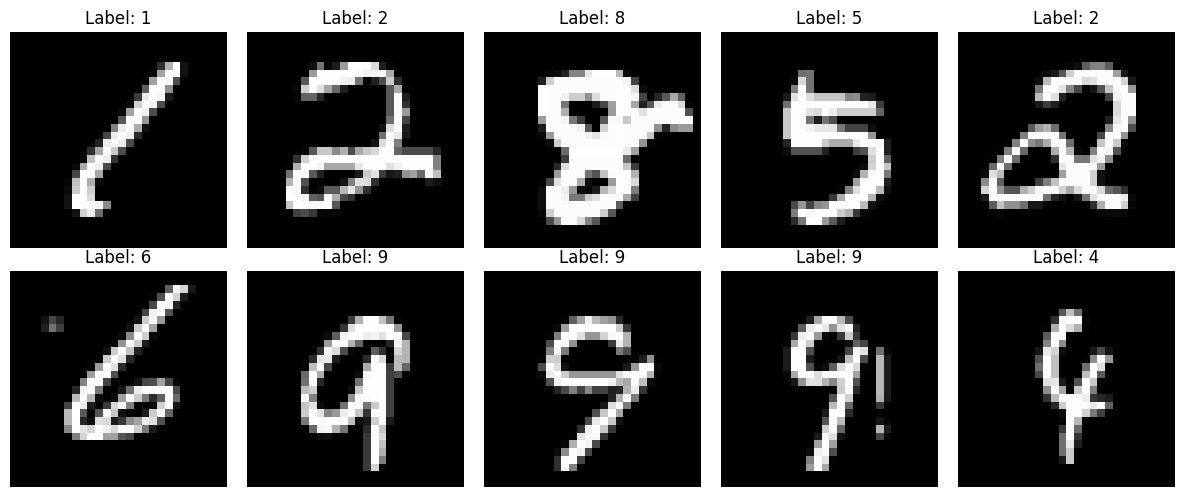

In [3]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    img = images[i].squeeze().numpy()
    img = (img + 1) / 2.0
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Классический подход к Conditional GAN

В оригинальной статье "Conditional Generative Adversarial Nets" (Mirza & Osindero, 2014) используется простой подход:

1. **Generator**: Принимает шум z и условие y (метку), объединяет их через конкатенацию: `concat(z, y)` → генерация изображения
2. **Discriminator**: Принимает изображение x и условие y, объединяет их через конкатенацию: `concat(x, y)` → классификация real/fake

**Ключевая идея**: Условие (метка) просто добавляется к входным данным через конкатенацию, без сложных проекций или embedding слоев.

## Архитектура Conditional Generator (классический подход)

Генератор принимает случайный вектор (шум) и метку класса (0-9). В классическом подходе метка представляется как one-hot вектор и конкатенируется с шумом.


In [4]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super().__init__()
        ...


## Архитектура Conditional Discriminator (классический подход)

Дискриминатор принимает изображение и метку класса. В классическом подходе изображение разворачивается в вектор, метка представляется как one-hot, и они конкатенируются перед подачей в сеть.


In [5]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ...


## PyTorch Lightning модуль для Conditional GAN

Создаем Lightning модуль, который объединяет генератор и дискриминатор, и реализует логику обучения Conditional GAN. На каждом шаге обучения передаем метки классов в обе сети.


In [6]:
class ConditionalGAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()
        
        self.automatic_optimization = False
        
        self.generator = ConditionalGenerator(latent_dim)
        self.discriminator = ConditionalDiscriminator()
        
        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        
        self.validation_labels = torch.arange(10).repeat(6)
        self.validation_z = torch.randn(60, latent_dim)
    
    def forward(self, z, labels):
        return self.generator(z, labels)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        ...
    
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.lr,
            betas=(self.b1, self.b2)
        )
        opt_d = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.lr,
            betas=(self.b1, self.b2)
        )
        return [opt_g, opt_d], []
    
    def on_train_epoch_end(self):
        save_dir = 'generated_images'
        os.makedirs(save_dir, exist_ok=True)
        
        z = self.validation_z.type_as(next(self.generator.parameters()))
        labels = self.validation_labels.type_as(z).long()
        sample_imgs = self.generator(z, labels)
        
        fig, axes = plt.subplots(6, 10, figsize=(15, 9))
        for i in range(60):
            ax = axes[i // 10, i % 10]
            img = sample_imgs[i].squeeze().detach().cpu().numpy()
            img = (img + 1) / 2.0
            ax.imshow(img, cmap='gray')
            ax.set_title(f'{labels[i].item()}', fontsize=8)
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'conditional_gan_epoch_{self.current_epoch:03d}.png'))
        plt.close()
        
        if self.logger:
            grid = utils.make_grid(sample_imgs.detach(), nrow=10, normalize=True)
            self.logger.experiment.add_image('generated_images', grid, self.current_epoch)


In [7]:
model = ConditionalGAN(latent_dim=100, lr=0.0002)

checkpoint_callback = ModelCheckpoint(
    monitor='g_loss',
    mode='min',
    save_top_k=1,
    filename='conditional-gan-mnist-{epoch:02d}-{g_loss:.4f}'
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True
)

trainer.fit(model, train_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | generator     | ConditionalGenerator     | 1.5 M  | train
1 | discriminator | ConditionalDiscriminator | 1.5 M  | train
-------------------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.838    Total estimated model params size (MB)
23        Modules in train mode
0   

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=50` reached.


## Визуализация результатов

Генерируем изображения для каждой цифры от 0 до 9, чтобы показать, что модель научилась генерировать нужные цифры по заданному числу.


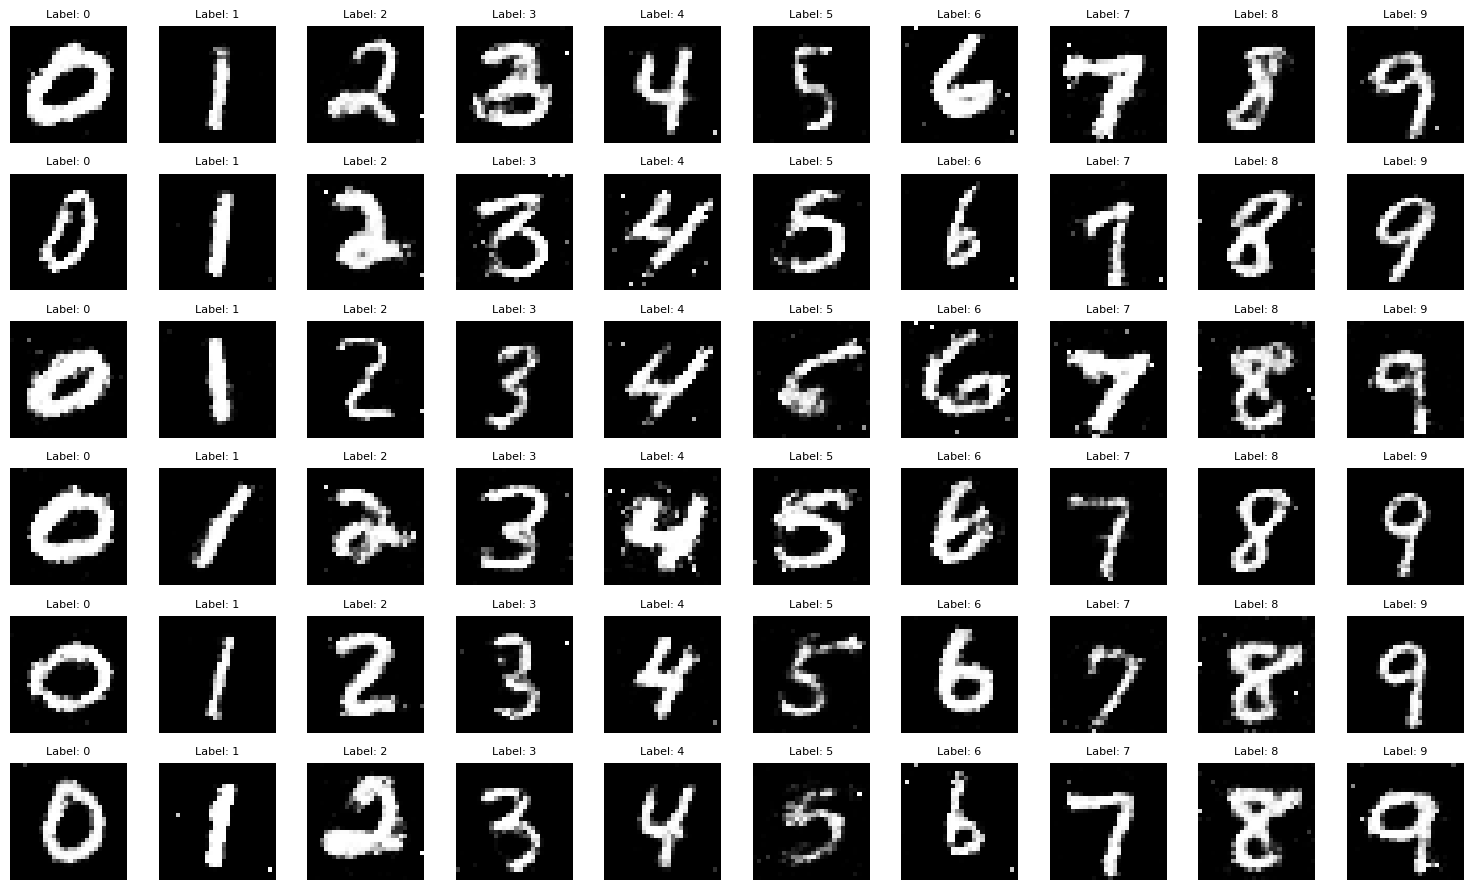

In [8]:
model.eval()
with torch.no_grad():
    labels_to_generate = torch.arange(10).repeat(6).type_as(next(model.generator.parameters())).long()
    z = torch.randn(60, 100)
    z = z.type_as(next(model.generator.parameters()))
    fake_imgs = model.generator(z, labels_to_generate)

fig, axes = plt.subplots(6, 10, figsize=(15, 9))
for i in range(60):
    ax = axes[i // 10, i % 10]
    img = fake_imgs[i].squeeze().cpu().numpy()
    img = (img + 1) / 2.0
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels_to_generate[i].item()}', fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()


## Генерация конкретных цифр

Теперь можно генерировать конкретные цифры, передавая нужное число в генератор.


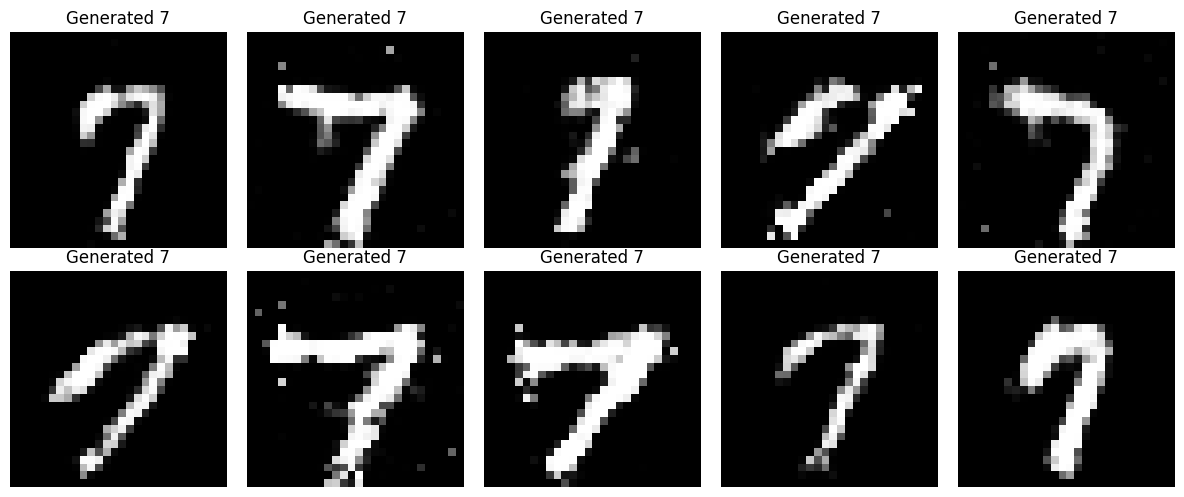

In [9]:
target_digit = 7
num_samples = 10

model.eval()
with torch.no_grad():
    z = torch.randn(num_samples, 100)
    z = z.type_as(next(model.generator.parameters()))
    labels = torch.full((num_samples,), target_digit).type_as(z).long()
    generated = model.generator(z, labels)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(num_samples):
    ax = axes[i // 5, i % 5]
    img = generated[i].squeeze().cpu().numpy()
    img = (img + 1) / 2.0
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Generated {target_digit}')
    ax.axis('off')
plt.tight_layout()
plt.show()
